![qiskit_header.png](../../images/qiskit_header.png)

# _*Qiskit Aqua: Amplitude Estimation*_ 

The latest version of this notebook is available on https://github.com/Qiskit/qiskit-iqx-tutorials.

***
### Contributors
Stefan Woerner<sup>[1]</sup>, Daniel Egger<sup>[1]</sup>, Shaohan Hu<sup>[1]</sup>, Stephen Wood<sup>[1]</sup>, Marco Pistoia<sup>[1]</sup>
### Affiliation
- <sup>[1]</sup>IBMQ

### Introduction
<br>
This notebook illustrates amplitude estimation in the simplest case, where the (assumed to be unknown) success probability $p$ of a Bernoulli random variable is estimated.
In other words, we assume a qubit is prepared in a state $\sqrt{1-p}\,\big|0\rangle + \sqrt{p}\,\big|1\rangle$, i.e., the probability of measuring $\big|1\rangle$ equals $p$.
This matches the results that have been demonstrated on real hardware in [1].
<br>
<br>
Amplitude estimation uses two operators: $A$ and $Q$, where $A$ describes the problem and $Q$ is derived from $A$ [2].
Here, $A = R_y(\theta_p)$, i.e., it equals a rotation with an angle $\theta_p = 2\sin^{-1}(\sqrt{p})$ around the Y-axis. For this single qubit case, $Q$ can  be represented by a Y-rotation around twice that angle, i.e., $Q = R_y(2\theta_p)$ [1]. 
This particularly implies that powers of the operator can be efficiently represented, i.e. $Q^k = R_y(2k\theta_p)$.
The result is then mapped into $m$ evaluation qubits. The larger $m$, the higher the accuracy of the estimation but also the longer the quantum circuit.
<br>
<br>
[1] <a href="https://arxiv.org/abs/1806.06893">Quantum Risk Analysis. Woerner, Egger. 2018.</a>
<br>
[2] <a href="https://arxiv.org/abs/quant-ph/0005055">Quantum Amplitude Amplification and Estimation. Brassard et al. 2000.</a>

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from qiskit.tools.visualization import plot_bloch_vector
from qiskit import BasicAer
from qiskit.aqua.algorithms import AmplitudeEstimation
from qiskit.aqua.algorithms.amplitude_estimators.q_factory import QFactory
from qiskit.aqua.components.uncertainty_problems import UncertaintyProblem

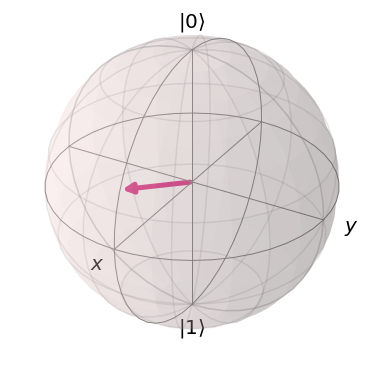

In [2]:
# the probability to be recovered
probability = 0.3
theta_p = 2*np.arcsin(np.sqrt(probability))

# the resulting quantum state after A is applied
plot_bloch_vector([np.sin(theta_p), 0.0, np.cos(theta_p)])

In [3]:
class BernoulliAFactory(UncertaintyProblem):
    """
    Circuit Factory representing the operator A.
    A is used to initialize the state as well as to construct Q.
    """
    
    def __init__(self, probability=0.5):
        # 
        super().__init__(1)
        self._probability = probability
        self.i_state = 0
        self._theta_p = 2 * np.arcsin(np.sqrt(probability))
    
    def build(self, qc, q, q_ancillas=None):
        
        # A is a rotation of angle theta_p around the Y-axis
        qc.ry(self._theta_p, q[self.i_state])


class BernoulliQFactory(QFactory):
    """
    Circuit Factory representing the operator Q.
    This implementation exploits the fact that powers of Q can be implemented efficiently by just multiplying the angle.
    (amplitude estimation only requires controlled powers of Q, thus, only this method is overridden.)
    """
    
    def __init__(self, bernoulli_expected_value):
        super().__init__(bernoulli_expected_value, i_objective=0)
    
    def build(self, qc, q, q_ancillas=None):
        i_state = self.a_factory.i_state
        theta_p = self.a_factory._theta_p
        # Q is a rotation of angle 2*theta_p around the Y-axis
        qc.ry(q[i_state], 2*theta_p)
    
    def build_controlled_power(self, qc, q, q_control, power, q_ancillas=None, use_basis_gates=True):
        i_state = self.a_factory.i_state
        theta_p = self.a_factory._theta_p
        qc.cry(2*power*theta_p, q_control, q[i_state])

In [4]:
# construct factories for A and Q
bernoulli_a_factory = BernoulliAFactory(probability)
bernoulli_q_factory = BernoulliQFactory(bernoulli_a_factory)

/Users/sergiogago/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: The BernoulliAFactory is deprecated as of Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, you can construct the circuits manually using the respective circuit components. See the tutorials for examples: github.com/Qiskit/qiskit-tutorials/tree/master/tutorials/finance
  
/Users/sergiogago/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/amplitude_estimators/q_factory.py:27: DeprecationWarning: The BernoulliQFactory is deprecated as of Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. You can use a qiskit.QuantumCircuit instead.
  super().__init__(a_factory.num_target_qubits)
/Users/sergiogago/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/amplitude_estimators/s_psi_0_reflection.py:21: DeprecationWarning: The SPsi0Factory is deprecated as of Aqua 0.8.0 and will be removed no earlie

In [5]:
# set number of evaluation qubits
m = 4

# construct amplitude estimation
# here, we override the standard construction of Q since we know a more efficient way
# (exploiting the fact that A and Q are just Y-rotations)
ae = AmplitudeEstimation(m, bernoulli_a_factory, q_factory=bernoulli_q_factory)

/Users/sergiogago/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/amplitude_estimators/ae.py:128: DeprecationWarning: Passing a CircuitFactory as A operator is deprecated as of 0.8.0, this feature will be removed no earlier than 3 months after the release. You should pass a QuantumCircuit instead.
  i_objective=i_objective)
/Users/sergiogago/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/amplitude_estimators/ae.py:128: DeprecationWarning: Passing a CircuitFactory as Q operator is deprecated as of 0.8.0, this feature will be removed no earlier than 3 months after the release. You should pass a QuantumCircuit instead.
  i_objective=i_objective)


In [6]:
# result = ae.run(quantum_instance=BasicAer.get_backend('qasm_simulator'))
result = ae.run(quantum_instance=BasicAer.get_backend('statevector_simulator'))

In [116]:
result

/Users/sergiogago/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



{'a_estimation': 0.5, 'confidence_interval': [0.4994139347918684, 0.5005860652081316], 'estimation': 0.5, 'num_oracle_queries': 130048, 'ml_value': 0.5, 'mapped_a_samples': [0.5], 'probabilities': [1.0], 'shots': 1024, 'mle': 0.5, 'circuit_result': {'0000011': 486, '0000010': 538}, 'a_samples': [(0.5, 1.0)], 'y_measurements': [(32, 0.525390625), (96, 0.474609375)], 'mapped_values': [0.5], 'max_probability': 1.0}

/Users/sergiogago/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/Users/sergiogago/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/amplitude_estimators/ae.py:668: DeprecationWarning:

values deprecated, use mapped_a_samples property.



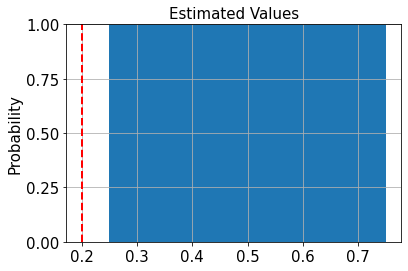

In [117]:
# plot estimated values
plt.bar(result['values'], result['probabilities'], width=0.5/len(result['probabilities']))
plt.plot([probability, probability], [0,1], 'r--', linewidth=2)
plt.xticks(size=15)
plt.yticks([0, 0.25, 0.5, 0.75, 1], size=15)
plt.title('Estimated Values', size=15)
plt.ylabel('Probability', size=15)
plt.ylim((0,1))
plt.grid()
plt.show()

/Users/sergiogago/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


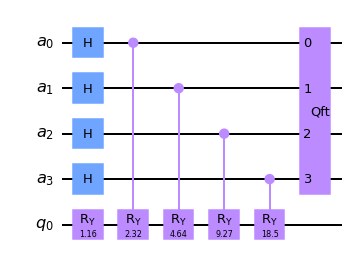

In [8]:
# plot circuit
ae._circuit.draw(output='mpl')

In [113]:
from qiskit import Aer, QuantumCircuit, execute
probability = 0.2
qc = QuantumCircuit(3)
theta = 2 * np.arcsin(np.sqrt(probability))
qc.ry(theta, 0)
qc.h([1,2])
qc.swap(0,1)
qc.draw()

/Users/sergiogago/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



┌────────────┐   
q_0: ┤ RY(0.9273) ├─X─
     └───┬───┬────┘ │ 
q_1: ────┤ H ├──────X─
         ├───┤        
q_2: ────┤ H ├────────
         └───┘

In [114]:
backend = Aer.get_backend('statevector_simulator')
job = execute(qc, backend, shots=1024)
counts = job.result().get_counts()
print(counts)

/Users/sergiogago/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



{'000': 0.2, '001': 0.2, '010': 0.05, '011': 0.05, '100': 0.2, '101': 0.2, '110': 0.05, '111': 0.05}


In [108]:
m = 7
ae = AmplitudeEstimation(m, qc)
result = ae.run(quantum_instance=BasicAer.get_backend('qasm_simulator'))

/Users/sergiogago/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



/Users/sergiogago/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/Users/sergiogago/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/amplitude_estimators/ae.py:668: DeprecationWarning:

values deprecated, use mapped_a_samples property.



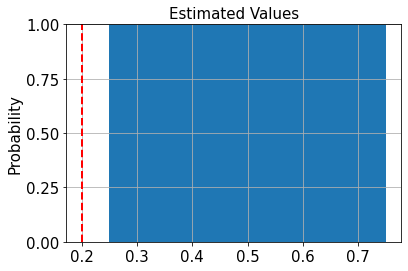

In [115]:
# plot estimated values
plt.bar(result['values'], result['probabilities'], width=0.5/len(result['probabilities']))
plt.plot([probability, probability], [0,1], 'r--', linewidth=2)
plt.xticks(size=15)
plt.yticks([0, 0.25, 0.5, 0.75, 1], size=15)
plt.title('Estimated Values', size=15)
plt.ylabel('Probability', size=15)
plt.ylim((0,1))
plt.grid()
plt.show()

In [104]:
from qiskit.aqua.algorithms import IterativeAmplitudeEstimation
epsilon = 0.01
alpha = 0.05

# construct amplitude estimation
iae = IterativeAmplitudeEstimation(state_preparation=qc,
                                  epsilon=epsilon, alpha=alpha)
result = iae.run(quantum_instance=Aer.get_backend('qasm_simulator'), shots=100)

/Users/sergiogago/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [105]:
conf_int = np.array(result['confidence_interval'])
print('Estimated value:\t%.4f' % result['estimation'])
print('Confidence interval: \t[%.4f, %.4f]' % tuple(conf_int))

Estimated value:	0.4983
Confidence interval: 	[0.4954, 0.5013]


/Users/sergiogago/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

